# Compare Temperature at 2m between ERA5 and GHCND.

In [133]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import scipy
import cftime
import cartopy
import cartopy.crs as ccrs
import matplotlib.colors as colors
import cmaps
from xhistogram.xarray import histogram
import geopandas as gpd
from matplotlib import cm
import functions_utils

In [134]:
state_borders =\
cartopy.feature.NaturalEarthFeature(category='cultural',\
        name='admin_1_states_provinces_lakes', scale='50m', facecolor='none')

In [135]:
lon_min=190;lon_max=230
lat_min=55;lat_max=72

# READ STATIONS DATA

In [136]:
ifile='/Projects/RAPrototype/GHCND/GHCND_Tmin_Tmax_Tavg_US_30yr.nc'
dso = xr.open_dataset(ifile)
dso = dso.where((dso['latitude']<=lat_max)&(dso['latitude']>=lat_min),drop=True)
dso['TAVG'] = dso['TAVG'].where(dso['TAVG']>-1000)
dso['TAVG'] = dso['TAVG']/10. # degreeC instead of 10th of degreeC
dso = dso.sel(time=slice('1995-01-01','2025-06-30'))


# Get name of stations

In [137]:
Tstation=[]
for ip in range(0,len(dso['station'])):
  Tstation.append(dso['station'][ip].data.item())

# Remove stations due to too much value outside of raisonnable range and too many missing data

In [138]:
ist = [ 0,2, 7,8,10,13,16,17,18,19,22,23,24,25,26,28,30,33,37,38,39,43,44,46,50,51,52,55,57,58,60,61,62,65,66,67,70]

In [139]:
for ii in range(0,len(ist)):
  Tstation.remove(dso['station'][ist[ii]].data.item())

In [140]:
ds = dso.sel(station=np.array(Tstation))

/tmp/ipykernel_1375351/3204720594.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors=cm.get_cmap('turbo',len(ds['station']))


Text(0.5, 1.0, 'GHNCD stations - Alaska')

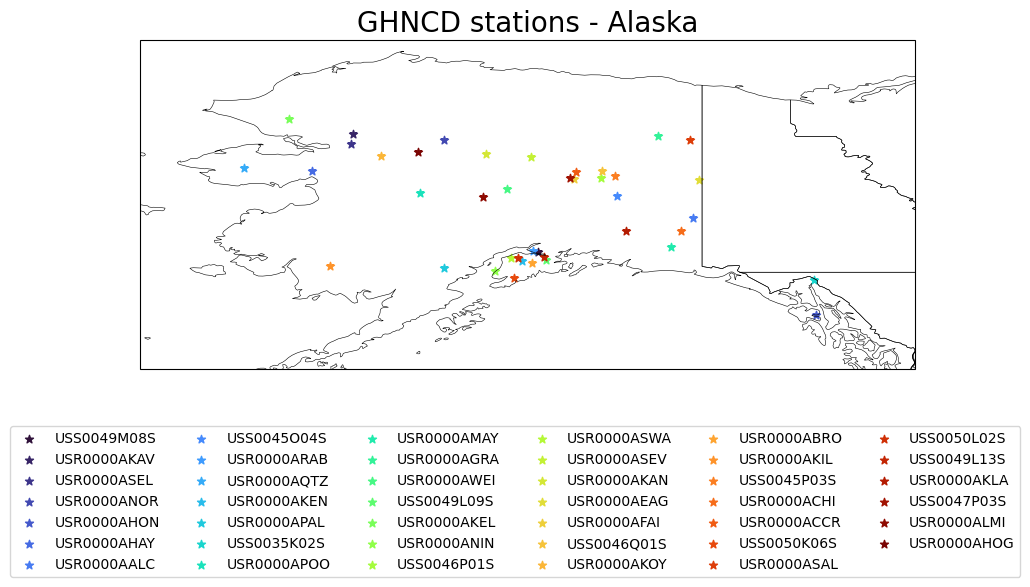

In [141]:
cmap=cmaps.BlGrYeOrReVi200
proj=ccrs.PlateCarree()
colors=cm.get_cmap('turbo',len(ds['station']))
#colors=cm.get_cmap('turbo',10)

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,11),subplot_kw={'projection':proj})

for ip in range(0,len(ds['station'])):
  #for ip in range(30,40):  
  ax.scatter(ds['longitude'][ip],ds['latitude'][ip],marker='*',color=colors(ip),label=ds['station'][ip].data.item())

ax.set_extent([190,230,55,72],proj)
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center',ncol=6,bbox_to_anchor=(0.5,0.15),prop={'size': 10})
ax.set_title('GHNCD stations - Alaska',fontsize=20)

In [142]:
# READ ERA5 interpolated on GHCND 's stations.

In [143]:
temp_var='air'

ifile = '/Projects/RAPrototype/GHCND/era5_daily_air_GHCND_AK.nc'
dsera5=xr.open_dataset(ifile)
dsera5 = dsera5.sel(time=slice('1995-01-01','2025-12-31'))
dsera5 = dsera5.sel(station=np.array(Tstation))
dsera5=dsera5.load()


# Time matching GHCND and ERA5

In [144]:
obs = functions_utils.remove_outliers_seasons(ds['TAVG'],2)

/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


In [145]:
maskit = xr.where(np.isnan(obs)==False,1,0)

In [146]:
t2m = dsera5['T2m'].where(maskit==1)

In [147]:
units='$\degree$C'

In [148]:
t2m['time'] = obs['time']
t2m['station'] = obs['station']

In [149]:
rmse = xr.zeros_like(obs.mean('time'))*np.nan
corr = xr.zeros_like(obs.mean('time'))*np.nan
mbia = xr.zeros_like(obs.mean('time'))*np.nan

In [150]:
aobs = (obs.groupby('time.day') - obs.groupby('time.day').mean('time'))
at2m = (t2m.groupby('time.day') - t2m.groupby('time.day').mean('time'))

# PLOT RMSE

In [151]:
for ip in range(0,len(ds['station'])):
    rmse[ip] = np.sqrt(np.nanmean(obs.isel(station=ip) - t2m.isel(station=ip))**2)

/tmp/ipykernel_1375351/1171131338.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('turbo',len(clevs)-1)


Text(0.5, 0.98, 'RMSE GHNCD vs ERA5, Temperature at 2m')

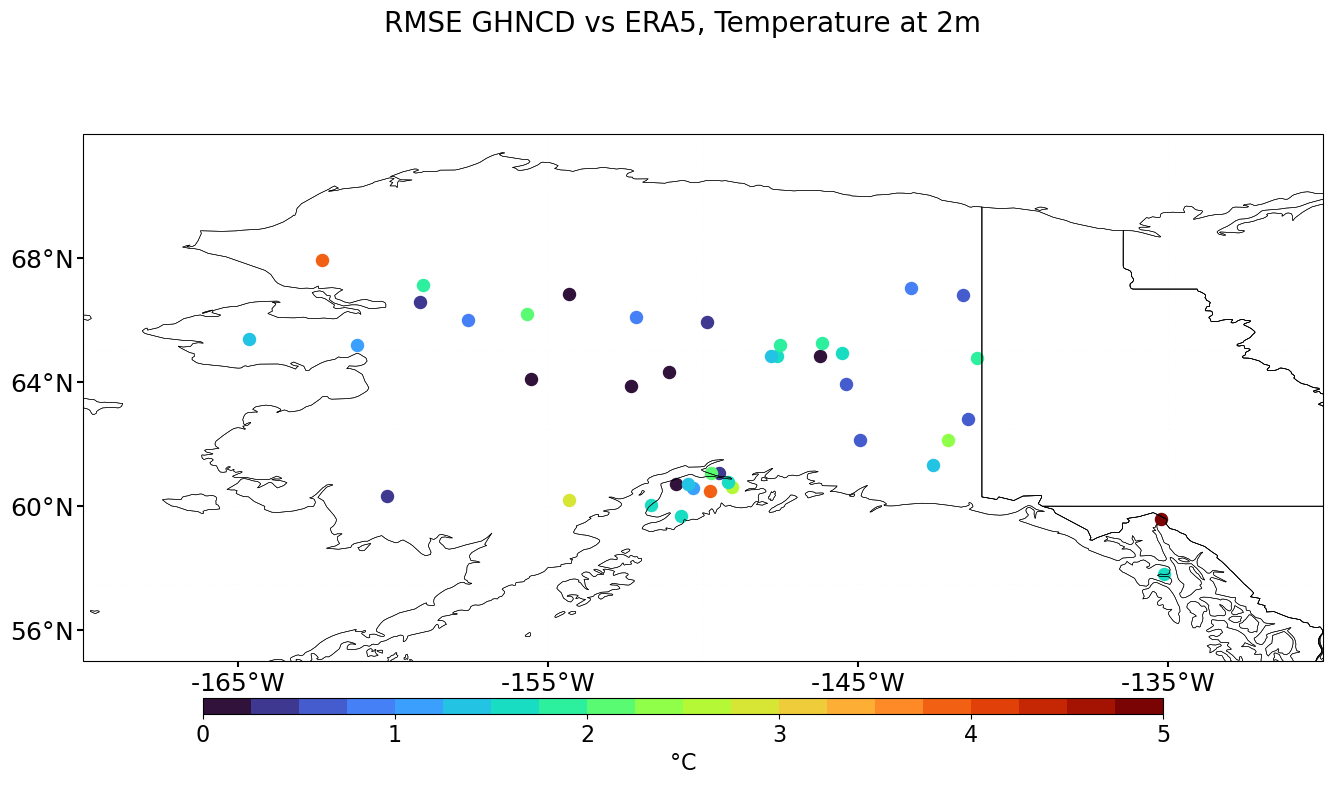

In [152]:
proj=ccrs.PlateCarree()
clevs=np.arange(0,5.25,0.25)
cmap=cm.get_cmap('turbo',len(clevs)-1)

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(16,8),subplot_kw={'projection':proj})

for ip in range(0,len(ds['station'])):
  #for ip in range(30,40):  
  cc=ax.scatter(ds['longitude'][ip],ds['latitude'][ip],c=rmse[ip],vmin=clevs[0],vmax=clevs[-1],marker='o',cmap=cmap,s=75)

cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])
cbar=fig.colorbar(cc, cax=cbar_ax,orientation='horizontal',label=units)
cbar.set_label(label=units,fontsize=16)
cbar.ax.tick_params(labelsize=16)
ax.set_extent([190,230,55,72],proj)
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
grd = ax.gridlines(
draw_labels=False, 
color='gray', alpha=0.01, linestyle='--')

ax.set_xlabel('')
ax.set_ylabel('')
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
ax.tick_params(axis='both',direction='out',width=1.5,length=4)
ax.set_yticks(ax.get_yticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax.get_yticks()],size=18)
ax.set_xticks(ax.get_xticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_xticklabels([f'{round(ixx)}$\degree$W' for ixx in ax.get_xticks()],size=18)
plt.suptitle('RMSE GHNCD vs ERA5, Temperature at 2m',fontsize=20)

# PLOT Mean Bias

In [153]:
for ip in range(0,len(ds['station'])):
    mbia[ip] = (np.nanmean(obs.isel(station=ip)) - np.nanmean(t2m.isel(station=ip)))

/tmp/ipykernel_1375351/3850732596.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('coolwarm',len(clevs)-1)


Text(0.5, 0.98, 'Mean Bias GHNCD vs ERA5, Temperature at 2m')

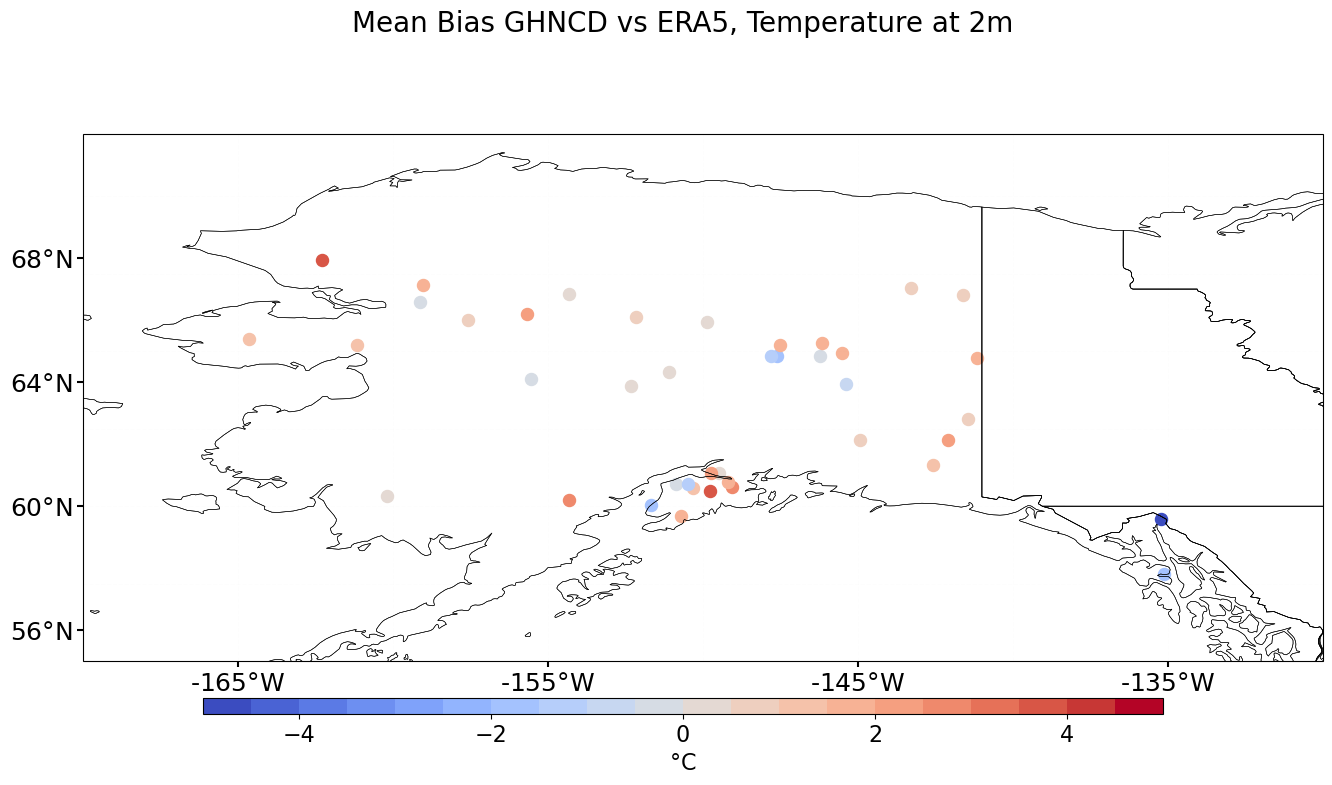

In [154]:
proj=ccrs.PlateCarree()
clevs=np.arange(-5,5.5,0.5)
cmap=cm.get_cmap('coolwarm',len(clevs)-1)

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(16,8),subplot_kw={'projection':proj})

for ip in range(0,len(ds['station'])):
  #for ip in range(30,40):  
  cc=ax.scatter(ds['longitude'][ip],ds['latitude'][ip],c=mbia[ip],vmin=clevs[0],vmax=clevs[-1],marker='o',cmap=cmap,s=75)

cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])
cbar=fig.colorbar(cc, cax=cbar_ax,orientation='horizontal',label=units)
cbar.set_label(label=units,fontsize=16)
cbar.ax.tick_params(labelsize=16)
ax.set_extent([190,230,55,72],proj)
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
grd = ax.gridlines(
draw_labels=False, 
color='gray', alpha=0.01, linestyle='--')

ax.set_xlabel('')
ax.set_ylabel('')
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
ax.tick_params(axis='both',direction='out',width=1.5,length=4)
ax.set_yticks(ax.get_yticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax.get_yticks()],size=18)
ax.set_xticks(ax.get_xticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_xticklabels([f'{round(ixx)}$\degree$W' for ixx in ax.get_xticks()],size=18)
plt.suptitle('Mean Bias GHNCD vs ERA5, Temperature at 2m',fontsize=20)

In [155]:
ds['latitude'].max()

<xarray.DataArray 'latitude' ()>
array(67.9333)

In [156]:
np.where(ds['latitude']>67.9)

(array([18]),)

# PLOT Correlation

In [157]:
for ip in range(0,len(ds['station'])):
    xxx = np.where(np.isnan(aobs.isel(station=ip))==False)[0]
    corr[ip] = np.corrcoef(aobs.isel(station=ip)[xxx],at2m.isel(station=ip)[xxx])[0][1]

/tmp/ipykernel_1375351/4034881522.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('Reds',len(clevs)-1)


Text(0.5, 0.98, 'Correlation GHNCD vs ERA5, Daily Anomaly of Temperature at 2m')

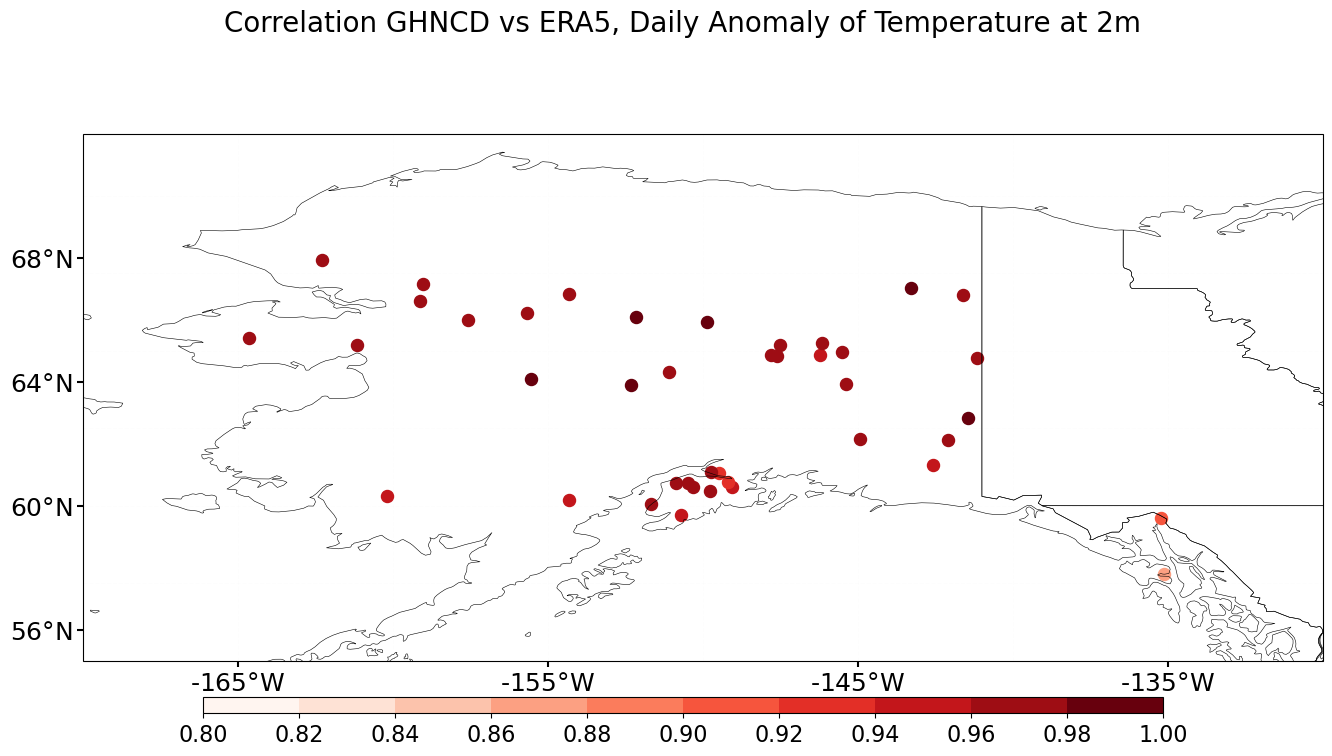

In [162]:
proj=ccrs.PlateCarree()
clevs=np.arange(0.8,1.02,0.02)
cmap=cm.get_cmap('Reds',len(clevs)-1)

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(16,8),subplot_kw={'projection':proj})

for ip in range(0,len(ds['station'])):
  cc=ax.scatter(ds['longitude'][ip],ds['latitude'][ip],c=corr[ip],vmin=clevs[0],vmax=clevs[-1],marker='o',cmap=cmap,s=75)

cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])
cbar=fig.colorbar(cc, cax=cbar_ax,orientation='horizontal',label='',ticks=clevs)
cbar.set_label(label='',fontsize=16)
cbar.ax.tick_params(labelsize=16)
ax.set_extent([190,230,55,72],proj)
grd = ax.gridlines(
draw_labels=False, 
color='gray', alpha=0.01, linestyle='--')

ax.set_xlabel('')
ax.set_ylabel('')
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
ax.tick_params(axis='both',direction='out',width=1.5,length=4)
ax.set_yticks(ax.get_yticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax.get_yticks()],size=18)
ax.set_xticks(ax.get_xticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_xticklabels([f'{round(ixx)}$\degree$W' for ixx in ax.get_xticks()],size=18)
plt.suptitle('Correlation GHNCD vs ERA5, Daily Anomaly of Temperature at 2m',fontsize=20)

# Some timeseries

/tmp/ipykernel_1375351/2958673836.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('coolwarm',len(clevs)-1)
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1696: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  result = super().scatter(*args, **kwargs)
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1696: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  result = super().scatter(*args, **kwargs)
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1696: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  result = super().scatter(*args, **kwargs)
/home/ghe

Text(0.5, 0.98, 'Mean Bias GHNCD vs ERA5, Temperature at 2m')

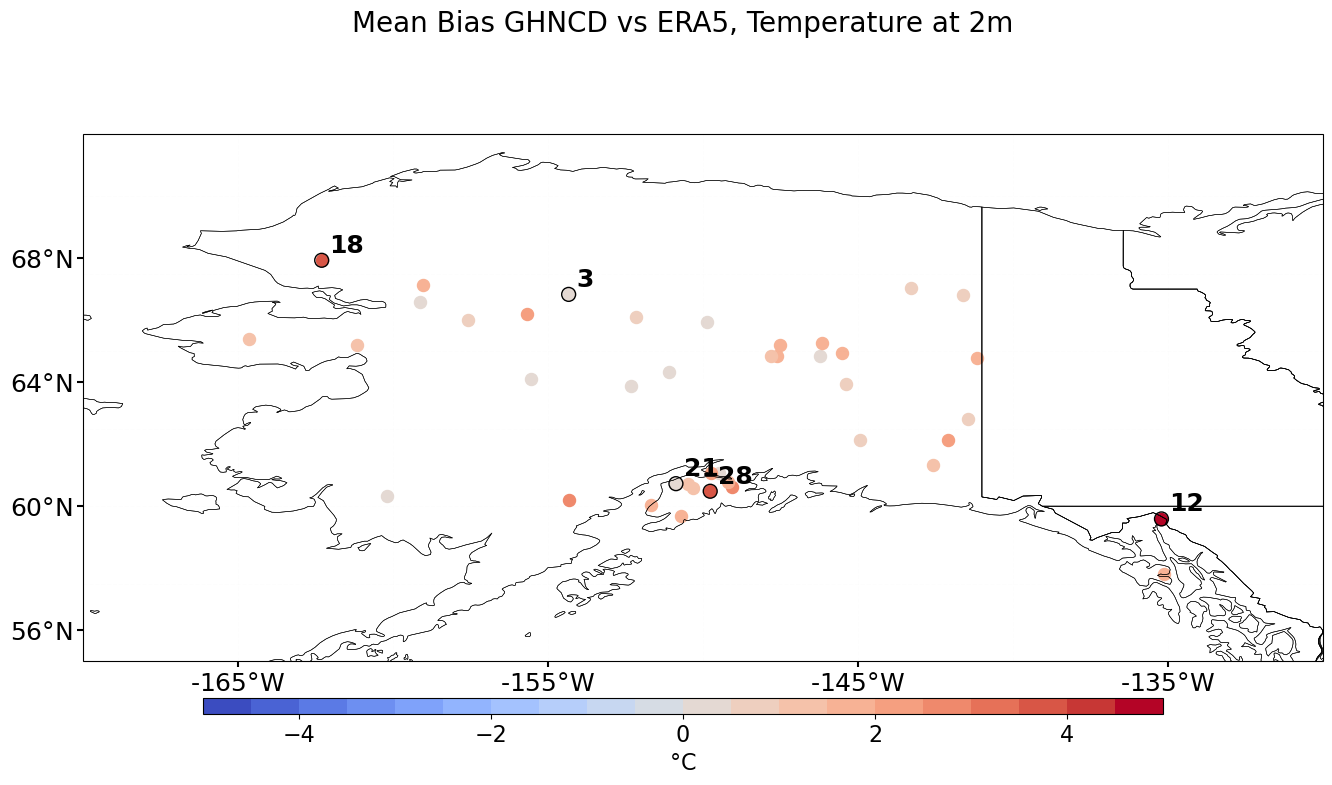

In [ ]:
Tip=[3,12,18,21,28]
proj=ccrs.PlateCarree()
clevs=np.arange(-5,5.5,0.5)
cmap=cm.get_cmap('coolwarm',len(clevs)-1)

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(16,8),subplot_kw={'projection':proj})

for ip in range(0,len(ds['station'])):
  cc=ax.scatter(ds['longitude'][ip],ds['latitude'][ip],c=rmse[ip],vmin=clevs[0],vmax=clevs[-1],marker='o',cmap=cmap,s=75)
for ip in Tip:
  ax.scatter(ds['longitude'][ip],ds['latitude'][ip],ec='k',fc='None',marker='o',cmap=cmap,s=100)
  ax.text(ds['longitude'][ip]+0.25,ds['latitude'][ip]+0.25,f'{ip}',color='k',size=18,weight='bold')
cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])
cbar=fig.colorbar(cc, cax=cbar_ax,orientation='horizontal',label=units)
cbar.set_label(label=units,fontsize=16)
cbar.ax.tick_params(labelsize=16)
ax.set_extent([190,230,55,72],proj)
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
grd = ax.gridlines(
draw_labels=False, 
color='gray', alpha=0.01, linestyle='--')

ax.set_xlabel('')
ax.set_ylabel('')
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
ax.tick_params(axis='both',direction='out',width=1.5,length=4)
ax.set_yticks(ax.get_yticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax.get_yticks()],size=18)
ax.set_xticks(ax.get_xticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_xticklabels([f'{round(ixx)}$\degree$W' for ixx in ax.get_xticks()],size=18)
plt.suptitle('RMSE GHNCD vs ERA5, Temperature at 2m',fontsize=20)

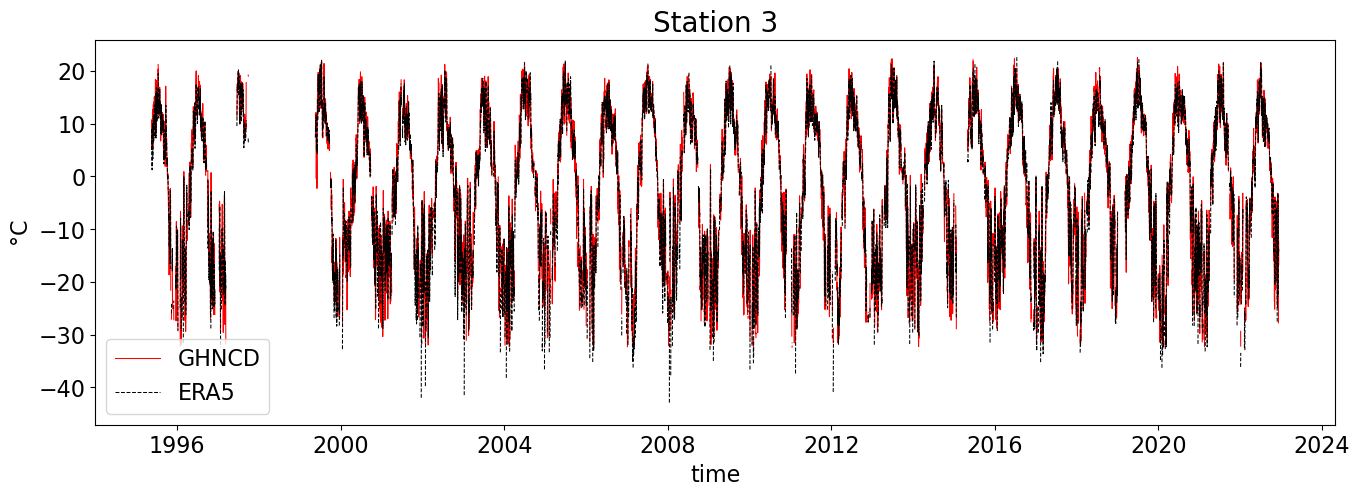

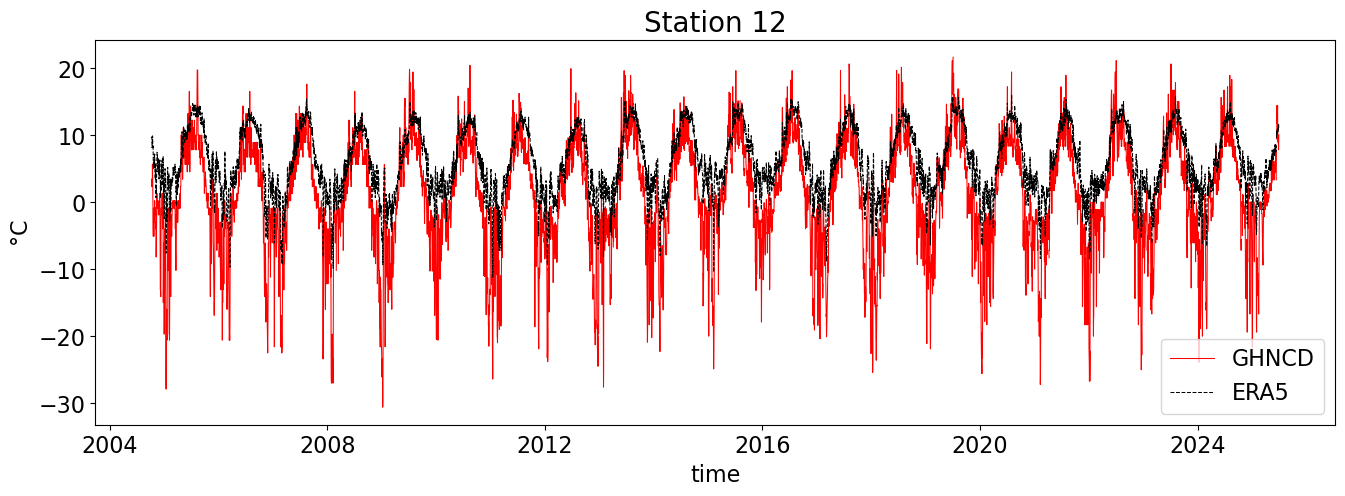

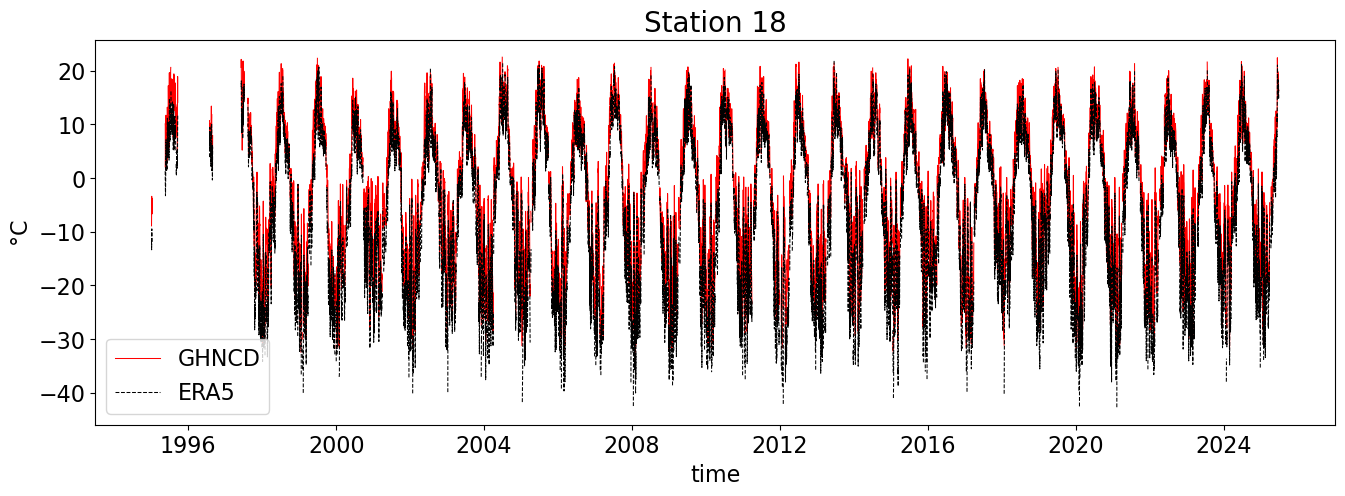

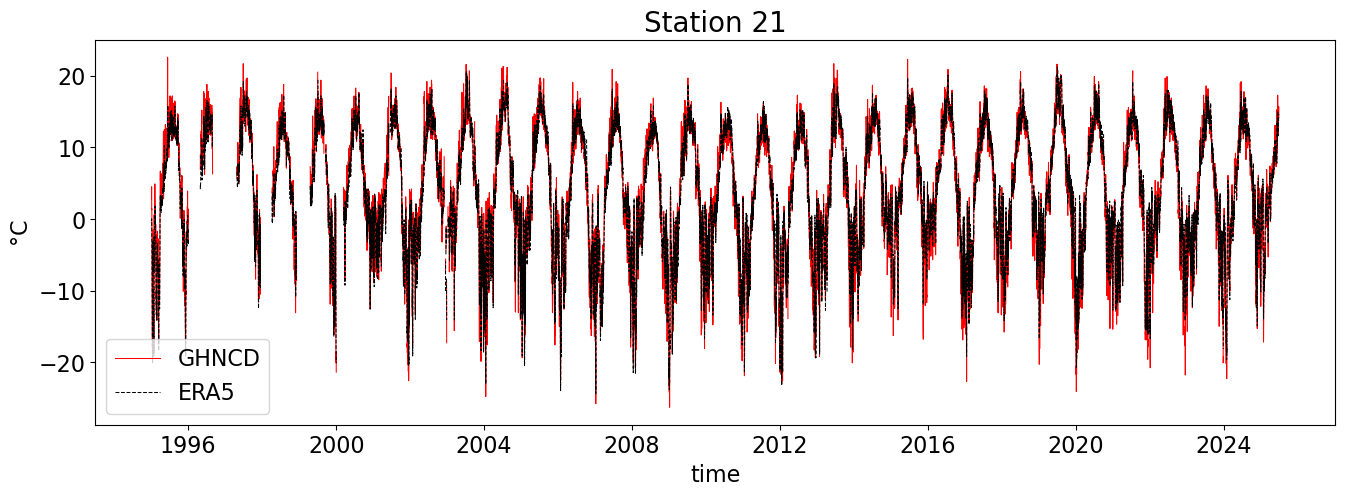

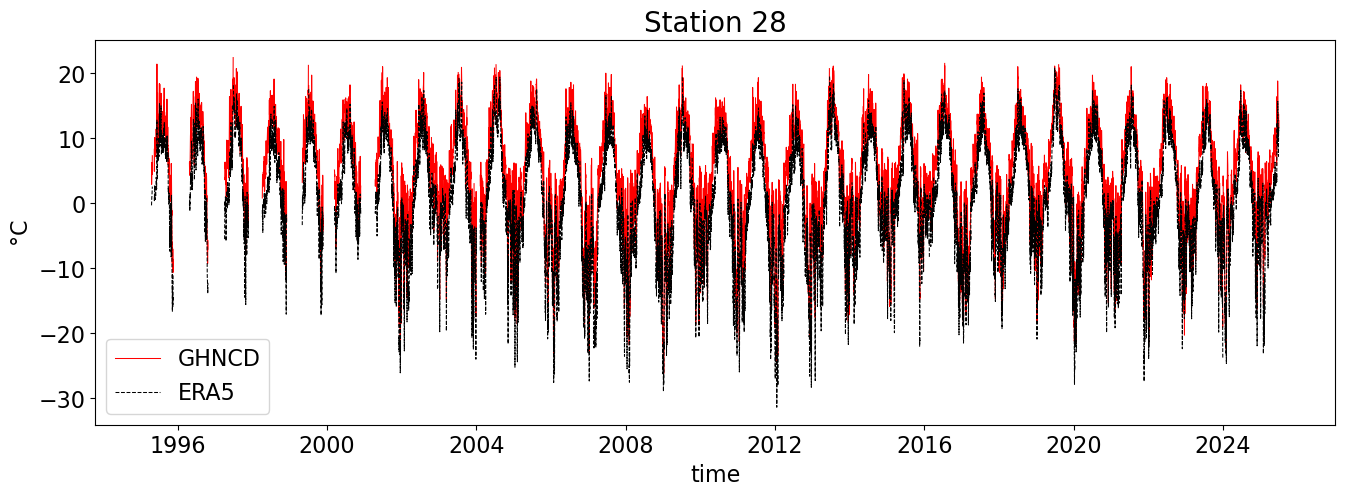

In [160]:
for ip in Tip:
  fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(16,5))
  ax.plot(ds['time'],obs.isel(station=ip),color='r',linewidth=0.75,label='GHNCD')
  ax.plot(ds['time'],t2m.isel(station=ip),color='k',linewidth=0.75,linestyle='--',label='ERA5')
  ax.tick_params(labelsize=16)
  plt.legend(loc='best',prop={'size': 16})
  plt.ylabel(f'$\degree$C',fontsize=16)  
  plt.xlabel('time',fontsize=16)
  plt.title(f'Station {ip}',fontsize=20)
  plt.show()